# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


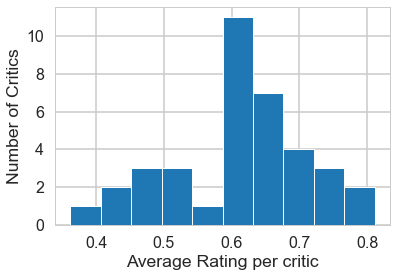

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?

Knowing that the range for movie ratings is from 0.0 - 1.0 we would assume that the mean would be around 0.5. The rating is a relative value and not absolute because the movie review is being compared against other movies as well. The movie rating would have a normal distribution and the critic reviews would be the same. 
The historgram from this dataset shows the distribution of ratings by critics that have reviewed more than a 100 movies. Approximately 80% of the critics rate a majority of the movies they review as fresh. Reasons for this observation would be that they they enjoy movies and with this bias they positively review as fresh. They are watching movies that are recommended as fresh by other critics.
We can observe the the distribution of average movie rating of critics varying the number of movies they reviewed. Below is the distribution of average ratings by critics with a certain number of reviews.

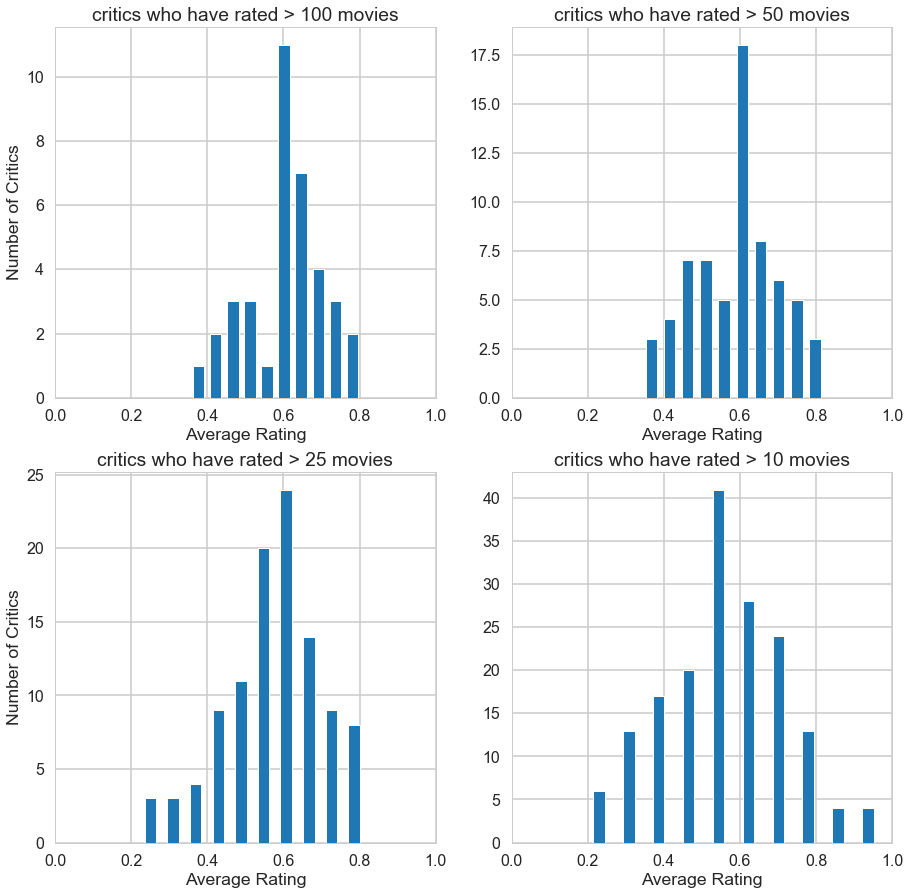

In [5]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

plt.rcParams["figure.figsize"] = (15,15)
fig, axes = plt.subplots(nrows=2, ncols=2)
wid=0.03
ax0, ax1, ax2, ax3 = axes.flatten()


ax0.hist(means[counts > 100],bins=10,width=wid,edgecolor='w',lw=1)
ax0.set_title("critics who have rated > 100 movies")
ax0.set_xlabel("Average Rating")
ax0.set_ylabel("Number of Critics")
ax0.set_xlim(0,1.0,auto=False)

ax1.hist(means[counts > 50],bins=10,edgecolor='w',width=wid,lw=1)
ax1.set_title("critics who have rated > 50 movies")
ax1.set_xlabel("Average Rating")
#ax1.set_ylabel("Number of Critics")
ax1.set_xlim(0,1.0,auto=False)


ax2.hist(means[counts > 25],bins=10,edgecolor='w',width=wid,lw=1)
ax2.set_title("critics who have rated > 25 movies")
ax2.set_xlabel("Average Rating")
ax2.set_ylabel("Number of Critics")
ax2.set_xlim(0,1.0,auto=False)

ax3.hist(means[counts > 10],bins=10,edgecolor='w',width=wid,lw=1)
ax3.set_title("critics who have rated > 10 movies")
ax3.set_xlabel("Average Rating")
#ax1.set_ylabel("Number of Critics")
ax3.set_xlim(0,1.0,auto=False)


plt.show()

Text(0.5,0,'Number of movies rated')

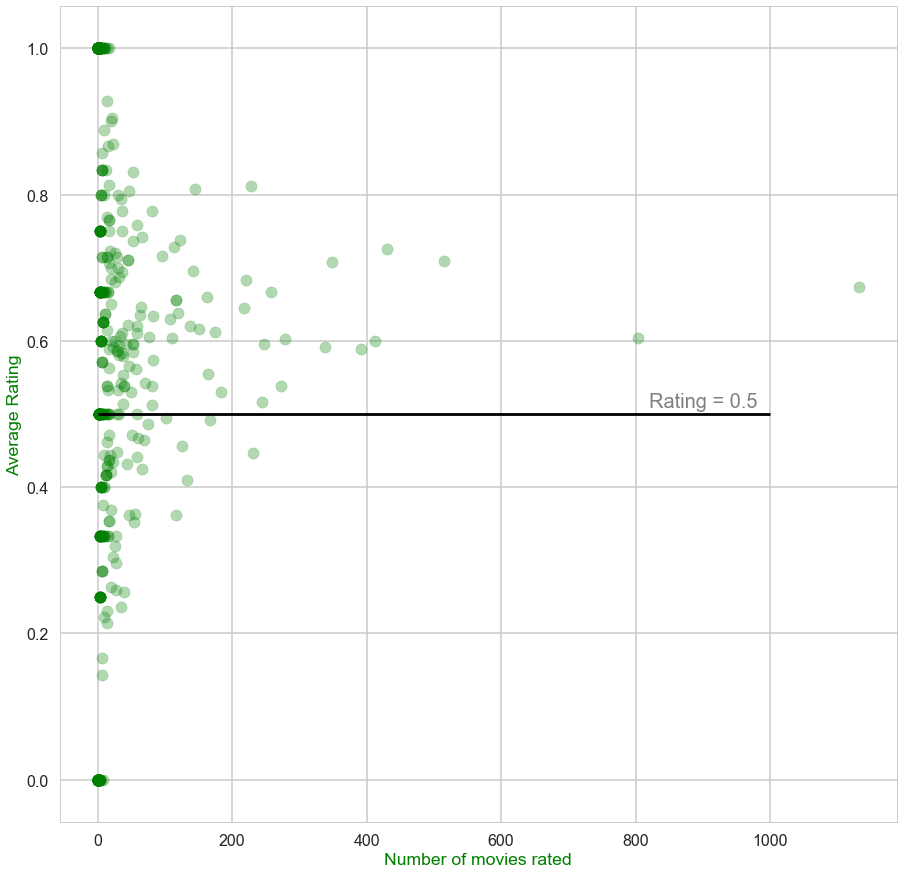

In [6]:
plt.scatter(counts.values, means.values, color='green',alpha=0.3)
plt.hlines(0.5,0,1000)
#plt.vlines(10,0,1.0)
plt.text(820, 0.51, 'Rating = 0.5',fontsize=20, color='grey')
plt.ylabel('Average Rating',color='green')
plt.xlabel('Number of movies rated',color='green')

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [8]:
text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
vectorizer = CountVectorizer()
TX = vectorizer.fit_transform(text)

In [9]:
TX.toarray()

array([[1, 0, 1, 1],
       [1, 1, 0, 1],
       [3, 0, 0, 0]], dtype=int64)

In [10]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$


<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?


In [11]:
#your turn

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [13]:
#Use scikit-learn's MultinomialNB() classifier with default parameters. 
clf = MultinomialNB()

In [14]:
#train the classifier over the training set and test on the test set 
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
#train the classifier over the training set and test on the test set 
print(clf.predict(X_test[2:5]))

[0 1 1]


In [16]:
y_test[2:5]

array([0, 0, 1])

In [17]:
#print the accuracy scores for both the training and the test sets 
print('training accuracy : %2.2f'  %(100*clf.score(X_train,y_train)))
print('testing accuracy  : %2.2f' %(100*clf.score(X_test,y_test)))

training accuracy : 92.13
testing accuracy  : 77.92


From the above observations the accuracy on training and testing data we can see that it is overfit. The accuracy needs to be improved. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.


<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>


In [18]:
# Your turn.
df_df = critics.copy()
#df_df['fresh'] = df_df.fresh == 'fresh'
df_df.quote = df_df.quote.str.lower()
df_df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"so ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,the year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,a winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,the film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"an entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [19]:
X_hp,y = make_xy(df_df)
df_word_f = pd.DataFrame(((X_hp>0).sum(axis=0).transpose()).A[:,0])
df_word_f=df_word_f.reset_index()
df_word_f.columns=['word','freq']
df_word_f.word=df_word_f.word+1
df_word_f.head()

,word,freq
0,1,7
1,2,1
2,3,10
3,4,1
4,5,1


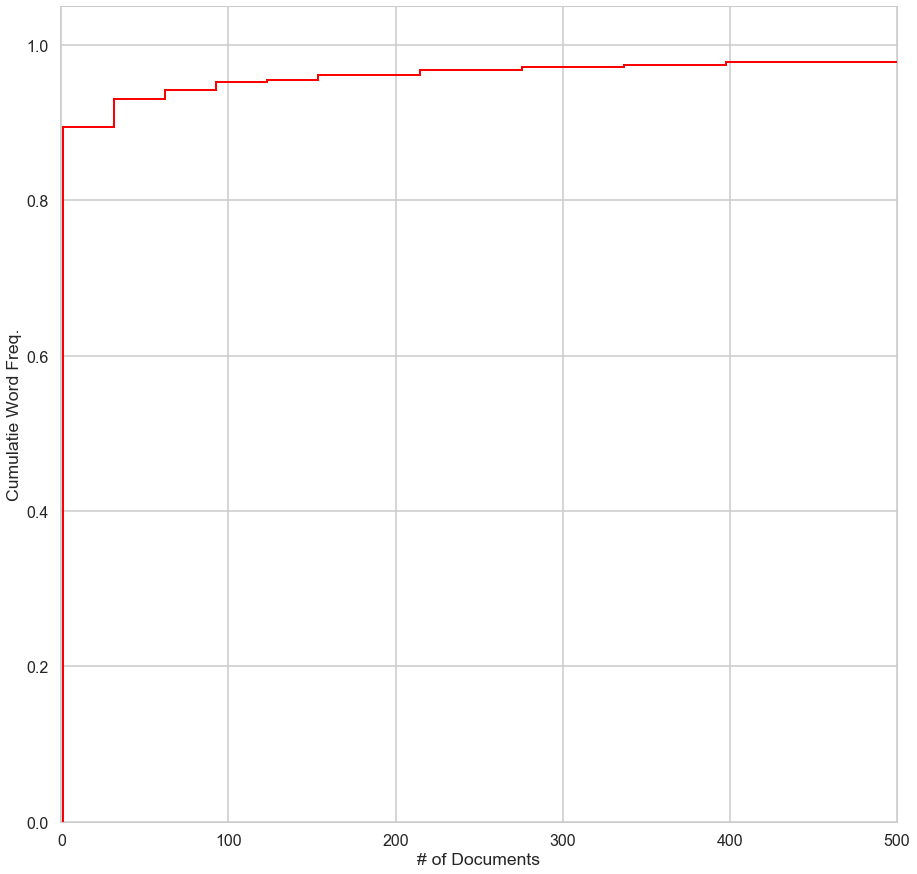

In [20]:
plt.hist(df_word_f.groupby(['freq']).size(),len(df_word_f['freq'].unique()),histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('# of Documents')
plt.ylabel('Cumulatie Word Freq.')
plt.show()

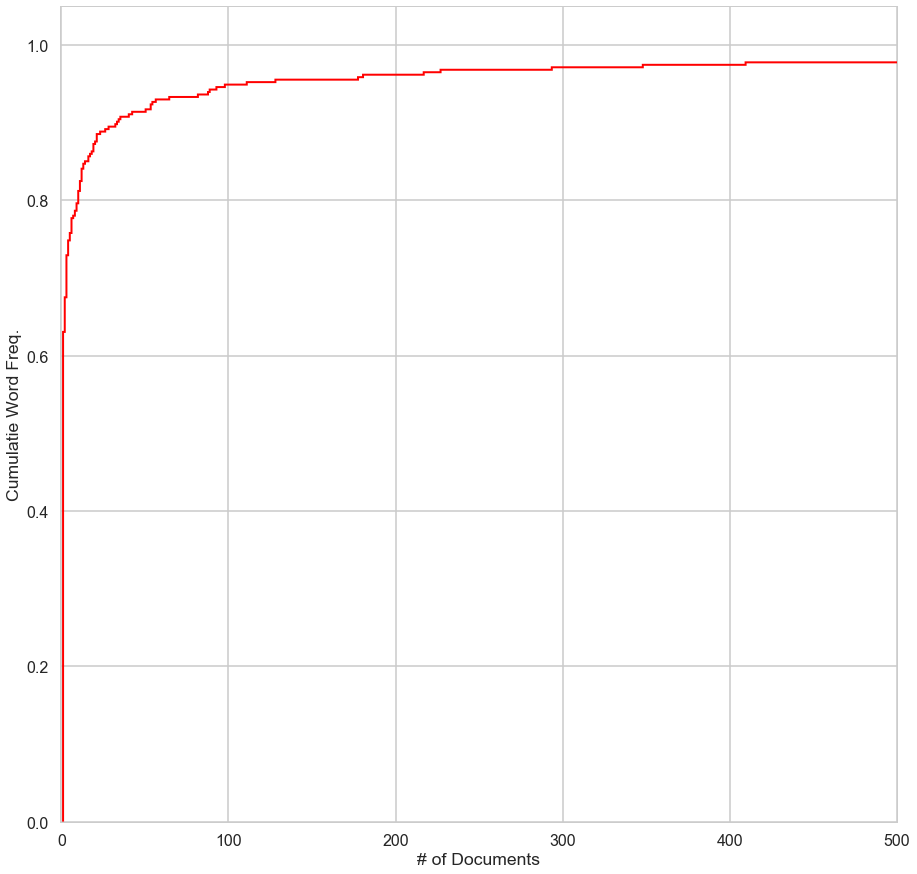

In [21]:
plt.hist(df_word_f.groupby(['freq']).size(),(df_word_f.groupby(['freq']).size()).index[-1],histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('# of Documents')
plt.ylabel('Cumulatie Word Freq.')
plt.show()

The curve above rises steeply after zero meaninf the minimum value would be close to zero for our purposes 0.001. The curve begins to plateau around 0.2 which may be an ideal maximum value. Once again the scores seem overfit and accuracy should be improved.  

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [22]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [23]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [24]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

C:\Users\Timus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)



<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>


Using log_likelihood as the score allows us to maximize the probability. We want ot be able to pick a model that has a higher probability to predict a particular class. 

An alpha is a smoothening parameter for the curve. A high alpha will have low accuracy where a low aplha would have no smooth curve. 

In [25]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs=[0.00001,0.0001,0.0005,0.0008,0.001,0.003,0.005]
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for mindf in min_dfs:
    for alpha in alphas:        
        vectorizer = CountVectorizer(min_df=mindf)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        print('alpha:',alpha,' min df:',mindf,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=mindf
print('\n','best alpha:',best_alpha,'best min df:',best_min_df,' max score',maxscore)

alpha: 0.1  min df: 1e-05  score: -1012.71790754
alpha: 1  min df: 1e-05  score: -745.908685869
alpha: 5  min df: 1e-05  score: -1251.01199809
alpha: 10  min df: 1e-05  score: -1396.21110872
alpha: 50  min df: 1e-05  score: -1347.06474472
alpha: 0.1  min df: 0.0001  score: -1017.39967543
alpha: 1  min df: 0.0001  score: -647.44015034
alpha: 5  min df: 0.0001  score: -996.727582764
alpha: 10  min df: 0.0001  score: -1207.3022501
alpha: 50  min df: 0.0001  score: -1295.29138837
alpha: 0.1  min df: 0.0005  score: -912.758696423
alpha: 1  min df: 0.0005  score: -615.936499522
alpha: 5  min df: 0.0005  score: -629.144140011
alpha: 10  min df: 0.0005  score: -791.580297666
alpha: 50  min df: 0.0005  score: -1120.95737752
alpha: 0.1  min df: 0.0008  score: -803.851778186
alpha: 1  min df: 0.0008  score: -603.20611825
alpha: 5  min df: 0.0008  score: -577.399038031
alpha: 10  min df: 0.0008  score: -676.871485869
alpha: 50  min df: 0.0008  score: -1027.48830644
alpha: 0.1  min df: 0.001  score

In [26]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
    print('alpha:',alpha,'score:',score)
    if score>maxscore:
        maxscore=score
        best_alpha=alpha
print('\n','best alpha:',best_alpha,'max score',maxscore)

alpha: 0.1 score: -745.537869123
alpha: 1 score: -594.180217964
alpha: 5 score: -564.277901842
alpha: 10 score: -638.599286512
alpha: 50 score: -981.331551867

 best alpha: 5 max score -564.277901842


In [27]:
print("alpha: {}".format(best_alpha))

alpha: 5


In [28]:
logprob = clf.predict_log_proba(Xtrainthis)
prob = clf.predict_proba(Xtrainthis)
temp_pred_df=pd.DataFrame(clf.predict(Xtrainthis))
temp_pred_df.columns=['Prediction']
temp_pred_df['class0LogProb']=logprob[:,0]
temp_pred_df['class1LogProb']=logprob[:,1]
temp_pred_df['class0Prob']=prob[:,0]
temp_pred_df['class1Prob']=prob[:,1]

In [29]:
temp_pred_df[(temp_pred_df.Prediction==0)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
317,0,-0.667927,-0.719020,0.512770,0.487230
1011,0,-0.448605,-1.017544,0.638518,0.361482
1559,0,-0.687052,-0.699280,0.503057,0.496943
1739,0,-0.665347,-0.721742,0.514095,0.485905
2050,0,-0.655556,-0.732207,0.519153,0.480847
2121,0,-0.572740,-0.830062,0.563978,0.436022
3075,0,-0.464609,-0.989886,0.628381,0.371619
3154,0,-0.569923,-0.833719,0.565569,0.434431
3417,0,-0.633439,-0.756648,0.530763,0.469237
3518,0,-0.623994,-0.767440,0.535800,0.464200


In [30]:
temp_pred_df[(temp_pred_df.Prediction==1)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
0,1,-2.501330,-0.085532,0.081976,0.918024
1,1,-1.269837,-0.329723,0.280877,0.719123
2,1,-4.178046,-0.015447,0.015328,0.984672
3,1,-2.553841,-0.080974,0.077782,0.922218
4,1,-1.443366,-0.269360,0.236132,0.763868
5,1,-0.825587,-0.576214,0.437978,0.562022
6,1,-5.072411,-0.006287,0.006267,0.993733
7,1,-1.085091,-0.412295,0.337871,0.662129
8,1,-2.424374,-0.092700,0.088534,0.911466
9,1,-2.611447,-0.076264,0.073428,0.926572



<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>


In [31]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print('min-df:',best_min_df)
print('alpha:',best_alpha)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

min-df: 0.001
alpha: 5
Accuracy on training data: 0.799100
Accuracy on test data:     0.716489


In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2069 2150]
 [ 938 5735]]


The model is more fit than previous attempts but the accuracy is less. 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [33]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.88
         intelligent 0.87
               witty 0.85
        entertaining 0.85
               charm 0.84
            pleasure 0.84
       entertainment 0.84
            touching 0.83
               smart 0.83
              brings 0.82
Bad words	     P(fresh | word)
                save 0.29
               feels 0.29
               fails 0.28
                dull 0.28
                flat 0.28
             instead 0.27
               worst 0.27
             premise 0.27
       unfortunately 0.25
               bland 0.23


<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>


This method works because it builds a review and classifies it based on a single word. The probability for each row in the identity matrix represents the classification as fresh or rotten. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [34]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
In this film [Hughes] has created a character who is every teen-ager's fantasy, but in the process he has lost some of the authenticity of his other films.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

Nava, who started his feature-film career with El Norte, is a good director who invariably finds a strong rapport with his actors. He's not much of a writer, though, and he should think twice about creating dialogue for his future projects.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

Mis-predicted Fresh quotes
------------

Exercise Set VII: Predicting the Freshness for a New Review
<br/>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?

In [35]:
#your turn
string = ['This movie is not remarkable, touching, or superb in any way']
x_test_q7 = vectorizer.transform(string)
print('Review -','\n',string,'\n')
if clf.predict(x_test_q7)[0]==1:
    print('predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7)[0,1]))
else:
    print('predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7)[0,0]))
print('\n')
        
#lets check what happens if we include a lot of 'Bad' words like uninspired, bad, worst
string_another_review = ['This movie is uninspired, bad and has been the worst movie that i have ever seen']
x_test_q7_2 = vectorizer.transform(string_another_review)
print('Review -','\n',string_another_review,'\n')
if clf.predict(x_test_q7_2)[0]==1:
    print('predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7_2)[0,1]))
else:
    print('predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7_2)[0,0]))
print('\n')

Review - 
 ['This movie is not remarkable, touching, or superb in any way'] 

predicted as Fresh with a probability of  95.52


Review - 
 ['This movie is uninspired, bad and has been the worst movie that i have ever seen'] 

predicted as Rotten with a probability of  64.03




The review should have been classified as rotten provided what the critic wrote about the movie. The critic stated that the movie was the opposite of all good things about a movie. The classifier interpreted this as fresh because of the words being mostly good words. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [36]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.

In [37]:
# Your turn
def clf_score(clf, x, y):
    score = clf.score(x,y)
    return score

In [38]:
def find_good_bad_words(vctrzr,clfr):
    words = np.array(vctrzr.get_feature_names())
    x = np.eye(len(words))
    probs = clfr.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [39]:
from sklearn.naive_bayes import MultinomialNB

alphas = [1,5,10,50]
ngrm_min_df = [0,0.00009,0.0001,0.001,0.005,0.01]
best_score=-np.inf
best_alpha, best_min_df = None, None
for alpha in alphas:
    for min_df in ngrm_min_df:
        vectorizer_n2 = CountVectorizer(min_df=min_df,ngram_range=(1, 2),token_pattern=r'\b\w+\b')       
        #vectorizer_n2 = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer_n2)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
        print('alpha :',alpha,' min_df :',min_df,' score :',score)
        if score > best_score:
            best_score=score
            best_alpha = alpha
            best_min_df = min_df

print('-----------------')
print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

alpha : 1  min_df : 0  score : 0.676370805419
alpha : 1  min_df : 9e-05  score : 0.707431072431
alpha : 1  min_df : 0.0001  score : 0.707431072431
alpha : 1  min_df : 0.001  score : 0.703578748299
alpha : 1  min_df : 0.005  score : 0.650460511669
alpha : 1  min_df : 0.01  score : 0.636109485416
alpha : 5  min_df : 0  score : 0.615329427074
alpha : 5  min_df : 9e-05  score : 0.630321933575
alpha : 5  min_df : 0.0001  score : 0.630321933575
alpha : 5  min_df : 0.001  score : 0.696721680196
alpha : 5  min_df : 0.005  score : 0.654315130901
alpha : 5  min_df : 0.01  score : 0.638037139296
alpha : 10  min_df : 0  score : 0.607832026274
alpha : 10  min_df : 9e-05  score : 0.609974730957
alpha : 10  min_df : 0.0001  score : 0.609974730957
alpha : 10  min_df : 0.001  score : 0.66716332615
alpha : 10  min_df : 0.005  score : 0.654528804643
alpha : 10  min_df : 0.01  score : 0.634824000312
alpha : 50  min_df : 0  score : 0.602264115434
alpha : 50  min_df : 9e-05  score : 0.602264115434
alpha : 5

In [40]:
vectorizer_n2 = CountVectorizer(min_df=best_min_df,ngram_range=(1, 2),token_pattern=r'\b\w+\b')  
#vectorizer_n2 = CountVectorizer(min_df=0.001,ngram_range=(1, 2),token_pattern=r'\b\w+\b')  
#vectorizer_n2 = CountVectorizer(min_df=0.001)  
X, y = make_xy(critics, vectorizer_n2)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.973870
Accuracy on test data:     0.744216


In [41]:
find_good_bad_words(vectorizer_n2,clf)

Good words	     P(fresh | word)
         masterpiece 0.97
         intelligent 0.97
               witty 0.96
            pleasure 0.96
            touching 0.96
           ever made 0.95
               sheer 0.94
               charm 0.94
             delight 0.94
                ford 0.94
Bad words	     P(fresh | word)
           ludicrous 0.13
                lame 0.13
     disappointingly 0.13
            not very 0.11
                save 0.11
          not enough 0.11
                   1 0.11
                or a 0.11
          feels like 0.09
               bland 0.08


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
mindfs=[0.00001,0.0005,0.0001,0.001]
#mindfs=[0.0005,0.0001]
for mindf in mindfs:
    vectorizer = CountVectorizer(min_df=mindf,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    Xtestthis = Xthis[~mask]
    ytestthis = ythis[~mask]
    feat=np.sqrt(len(vectorizer.get_feature_names()))
    parameters = {"n_estimators": [10,20,40,50,60,70],"max_features":['auto','sqrt','log2']}
    clf = RandomForestClassifier()
    fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
    fitmodel.fit(Xtrainthis, ytrainthis)
    print('-------min_df:',mindf)
    print('***best estimator:',fitmodel.best_estimator_)
    print('***best params:',fitmodel.best_params_)
    print('***best score:',fitmodel.best_score_)
    print('***grid scores:', fitmodel.grid_scores_)
    #score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
    #print(score)

In [ ]:
vectorizer = CountVectorizer(min_df=0.0005,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]
feat=np.sqrt(len(vectorizer.get_feature_names()))
parameters = {"n_estimators": [60,80,100,150,250],"max_features":['auto','sqrt','log2']}
clf = RandomForestClassifier()
fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
fitmodel.fit(Xtrainthis, ytrainthis)
print('-------min_df:',mindf)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
print('***grid scores:', fitmodel.grid_scores_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
vectorizer = CountVectorizer(min_df=0.0005,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]
clf = fitmodel.best_estimator_
score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
print(score)

In [ ]:
training_accuracy = clf.score(Xtrainthis, ytrainthis)
test_accuracy = clf.score(Xtestthis, ytestthis)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=1).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [ ]:
from sklearn.naive_bayes import MultinomialNB

alphas = [1,5,10,50]
min_dfs = [0,0.00009,0.0001,0.001,0.005,0.01]
#min_dfs = [0,0.00009,0.0001,0.001]
best_score=-np.inf
best_alpha,best_min_df = None,None

for alpha in alphas:
    for min_df in min_dfs:
        tfidfvectorizer = TfidfVectorizer(min_df=min_df,analyzer='word',stop_words='english',
                                          ngram_range=(1, 4),token_pattern=r'\b\w+\b')       
        #vectorizer_n2 = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, tfidfvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
        print(' min_df :',min_df,'alpha:',alpha,' score :',score)
        if score > best_score:
            best_score=score
            best_min_df = min_df
            best_alpha = alpha

print('-----------------')
print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df=best_min_df,analyzer='word',stop_words='english',
                                  ngram_range=(1, 4),token_pattern=r'\b\w+\b')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [ ]:
find_good_bad_words(tfidfvectorizer,clf)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
vectorizer_lda = CountVectorizer(min_df=0.00009,ngram_range=(1, 2),token_pattern=r'\b\w+\b') 

X, y = make_xy(critics, vectorizer_lda)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

In [ ]:
lda = LDA(n_topics=20)
lda.fit(xtrain)
training_features = lda.transform(xtrain)
testing_features=lda.transform(xtest)
xtrain_trn_feat=sp.sparse.hstack((xtrain,sp.sparse.csc_matrix(training_features)))
xtest_tst_feat=sp.sparse.hstack((xtest,sp.sparse.csc_matrix(testing_features)))

#clf = MultinomialNB(alpha=1).fit(xtrain_trn_feat, ytrain)

In [ ]:
clf = MultinomialNB(alpha=1).fit(xtrain_trn_feat, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain_trn_feat, ytrain)
test_accuracy = clf.score(xtest_tst_feat, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))